In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Data Preparation

First of all let us prepare the data, because our data is divided into a label file and a data file, these two needs to be merged. Our target to predict is "vacc_h1n1_f", which indicates whether a person is vaccinated(1) or not(0). The test data except the target variable is also provided.

To import data *pandas* library as awell as *sklearn*'s *train_test_split* are necessary

In [ ]:
# Import pandas and sklearn's train_test_split libraries
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the datasets
target = 'vacc_h1n1_f'
df = pd.merge(pd.read_csv('../input/prediction-of-h1n1-vaccination/train.csv'), 
                 pd.read_csv('../input/prediction-of-h1n1-vaccination/train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('../input/prediction-of-h1n1-vaccination/test.csv')

Next, we are going to split data for the purposes of training and validation using *train_test_split* 

In [ ]:
# Separate data for train 
train, val = train_test_split(df, train_size=0.80, test_size=0.20, stratify=df[target], random_state=2)

train.shape, val.shape, test.shape

# 2. EDA(Exploratory Data Analysis)

Let us have a quick overview of the training dataset by looking at its summary, utilizing *pandas_profiling* to generate a Profile Report.

In [ ]:
# Quick overview of the training dataset
from pandas_profiling import ProfileReport as pr
profile = pr(train, minimal=True).to_notebook_iframe()

## Observations:

* *state* variable has the highest cardinality
* Many of the features have at least have 20% of missing values out of their entirety
* There are some features that have more than half of their data as missing values

## Decisions:
1. The data with high cardinality could be removed
2. The missing values need to be imputed

For the next step, we will check whether there are duplicates in our training data.

In [ ]:
# Check duplicates
train.T.duplicated()

It seems that there is no duplicates. Good!

We found from the previous observation of our Profile Report that there are features with high cardinality. Let us see this in detail.

In [ ]:
# Check cardinality
train.describe(exclude='number')

There are about 12 categorical features identified within the dataset. *state*, which has the highest cardinality, is found to be 51. It is about twice as much as the cardinality of the *employment_occupation* feature, which is the second highest. Maybe we can get rid of *state* feature, as it may negatively impact the performance of our model.

## Feature Engineering

From the Profile Report generated beforehand, I found that the *employment_status* feature is also divided into three categories. Among these, I thought that "Not in Labor Force" could be converted to "Unemployed", since people in these categories are not economically active. (I know that not everyone would agree with such manipulation of the feature, but I am only doing this to see if it helps to improve the performance of our results.)

Also, a feature called *behaviorals* is created, in order to sum up all of the behavioral characteristics of the individuals. Any feature with over cardinality of 30, would be removed as well.



In [ ]:
# Feature engineering

def engineer(df):
    
    # Create "behaviorals" feature
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behaviorals'] = df[behaviorals].sum(axis=1)
    
    # Transform employment_status feature values("Not in Labor Force" -> "Unemployed")
    fixed_data = []
    for i in df["employment_status"]:
      if i == "Not in Labor Force":
        fixed_data.append("Unemployed")
      else:
        fixed_data.append(i)
    df["employment_status"] = fixed_data
    
    # Remove any feature with cardinality of over 30
    selected_cols = df.select_dtypes(include=['number', 'object'])
    colnames = selected_cols.columns.tolist()
    labels = selected_cols.nunique()
    
    selected_features = labels[labels <= 30].index.tolist()
    df = df[selected_features]
        
    return df


train = engineer(train)
val = engineer(val)
test = engineer(test)

Afterwards, we will separate the target feature from the training data. Then we will divide the training, validation, and testing data into independent(X) and dependent(y) variables.

In [ ]:
# Separate the target feature from the training data
features = train.drop(columns=[target]).columns

# Diving training, validation, and testing data into X and y
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# 3. Modelling

As we are going to model a Random Forest Classifier, *Ordinal Encoder* is a good choice for converting categorical features to numerical. For missing values, we will use a *Simple Imputer*. Then we will train the encoded and imputed data with a *Random Forest Classifier* model. All of these can be conveniently done with *Pipelines* of *sklearn* library. 

In [ ]:
# Import libraries for OrdinalEncoder, SimpleImputer, RandomForestClassifier, and make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

Let us create the model, using the training datasets including features that we created. Then let us see the score of how well our model performed by, evaluating with valdiation dataset. We would like the model to use as much CPU as possible so will set the *n_jobs* variable to -1, and as the Random Forest Classifier makes use of out-of-bag samples to test its accuracy, set *oob_score* to "True".

In [ ]:
%%time

# Using the Pipelines feature to perform encoding, imputation, and modelling all at once
pipe_ord = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=10, n_jobs=-1, oob_score=True)
)

pipe_ord.fit(X_train, y_train)
print('Validation Accuracy Score:', pipe_ord.score(X_val, y_val))

What about out-of-bag samples accuracy? Let us find out!

In [ ]:
# Out-of-Bag samples accuracy
pipe_ord.named_steps['randomforestclassifier'].oob_score_

There is only about 0.01 difference between the two scores. It seems that the model performed well with a very small overfit. 

So what would be our final prediction using the test data? Let us find out!

In [ ]:
# Predict the target using the testing data
y_pred_test = pipe_ord.predict(X_test)
y_pred_test = pd.Series(y_pred_test)
y_pred_test.value_counts()

Finally we will generate our submission file. We will need to form the dataset that has both the "id" information of the individual as well as our final prediciton, as required by the challenge. We will display our submission data to check if it was created alright. Finally, we will export the submission data to a *csv* file for actual submission.

In [ ]:
# Create the DataFrame including predictions with "id" feature from the original data as index 
id = pd.Series(range(len(y_pred_test)))
y_pred_test = pd.Series(y_pred_test)
submission = pd.concat([id, y_pred_test], axis=1)
submission.rename(columns={0:"id", 1:target}, inplace=True)

# Display the submission data information
print(submission.shape)
print(submission.value_counts(target))

# Export the dataset to a *csv* file.
submission.to_csv("./submission.csv",index=False)

The submission file is generated with as correct dimensions as it is required. The output file is generated as "submission.csv" in the Kaggle directory. Let us submit it and find out the results!

# 4. Submission Results

The score was actually lower than expected. It only scored about 0.33. It actually scored far lower than my second submission, which included the Random Classifier model trained on all of the features with those of high cardinality. This indicated me that maybe removing high-cardinality features was afar from the ideal solution. Perhaps, I can think about different approaches to improve the model.

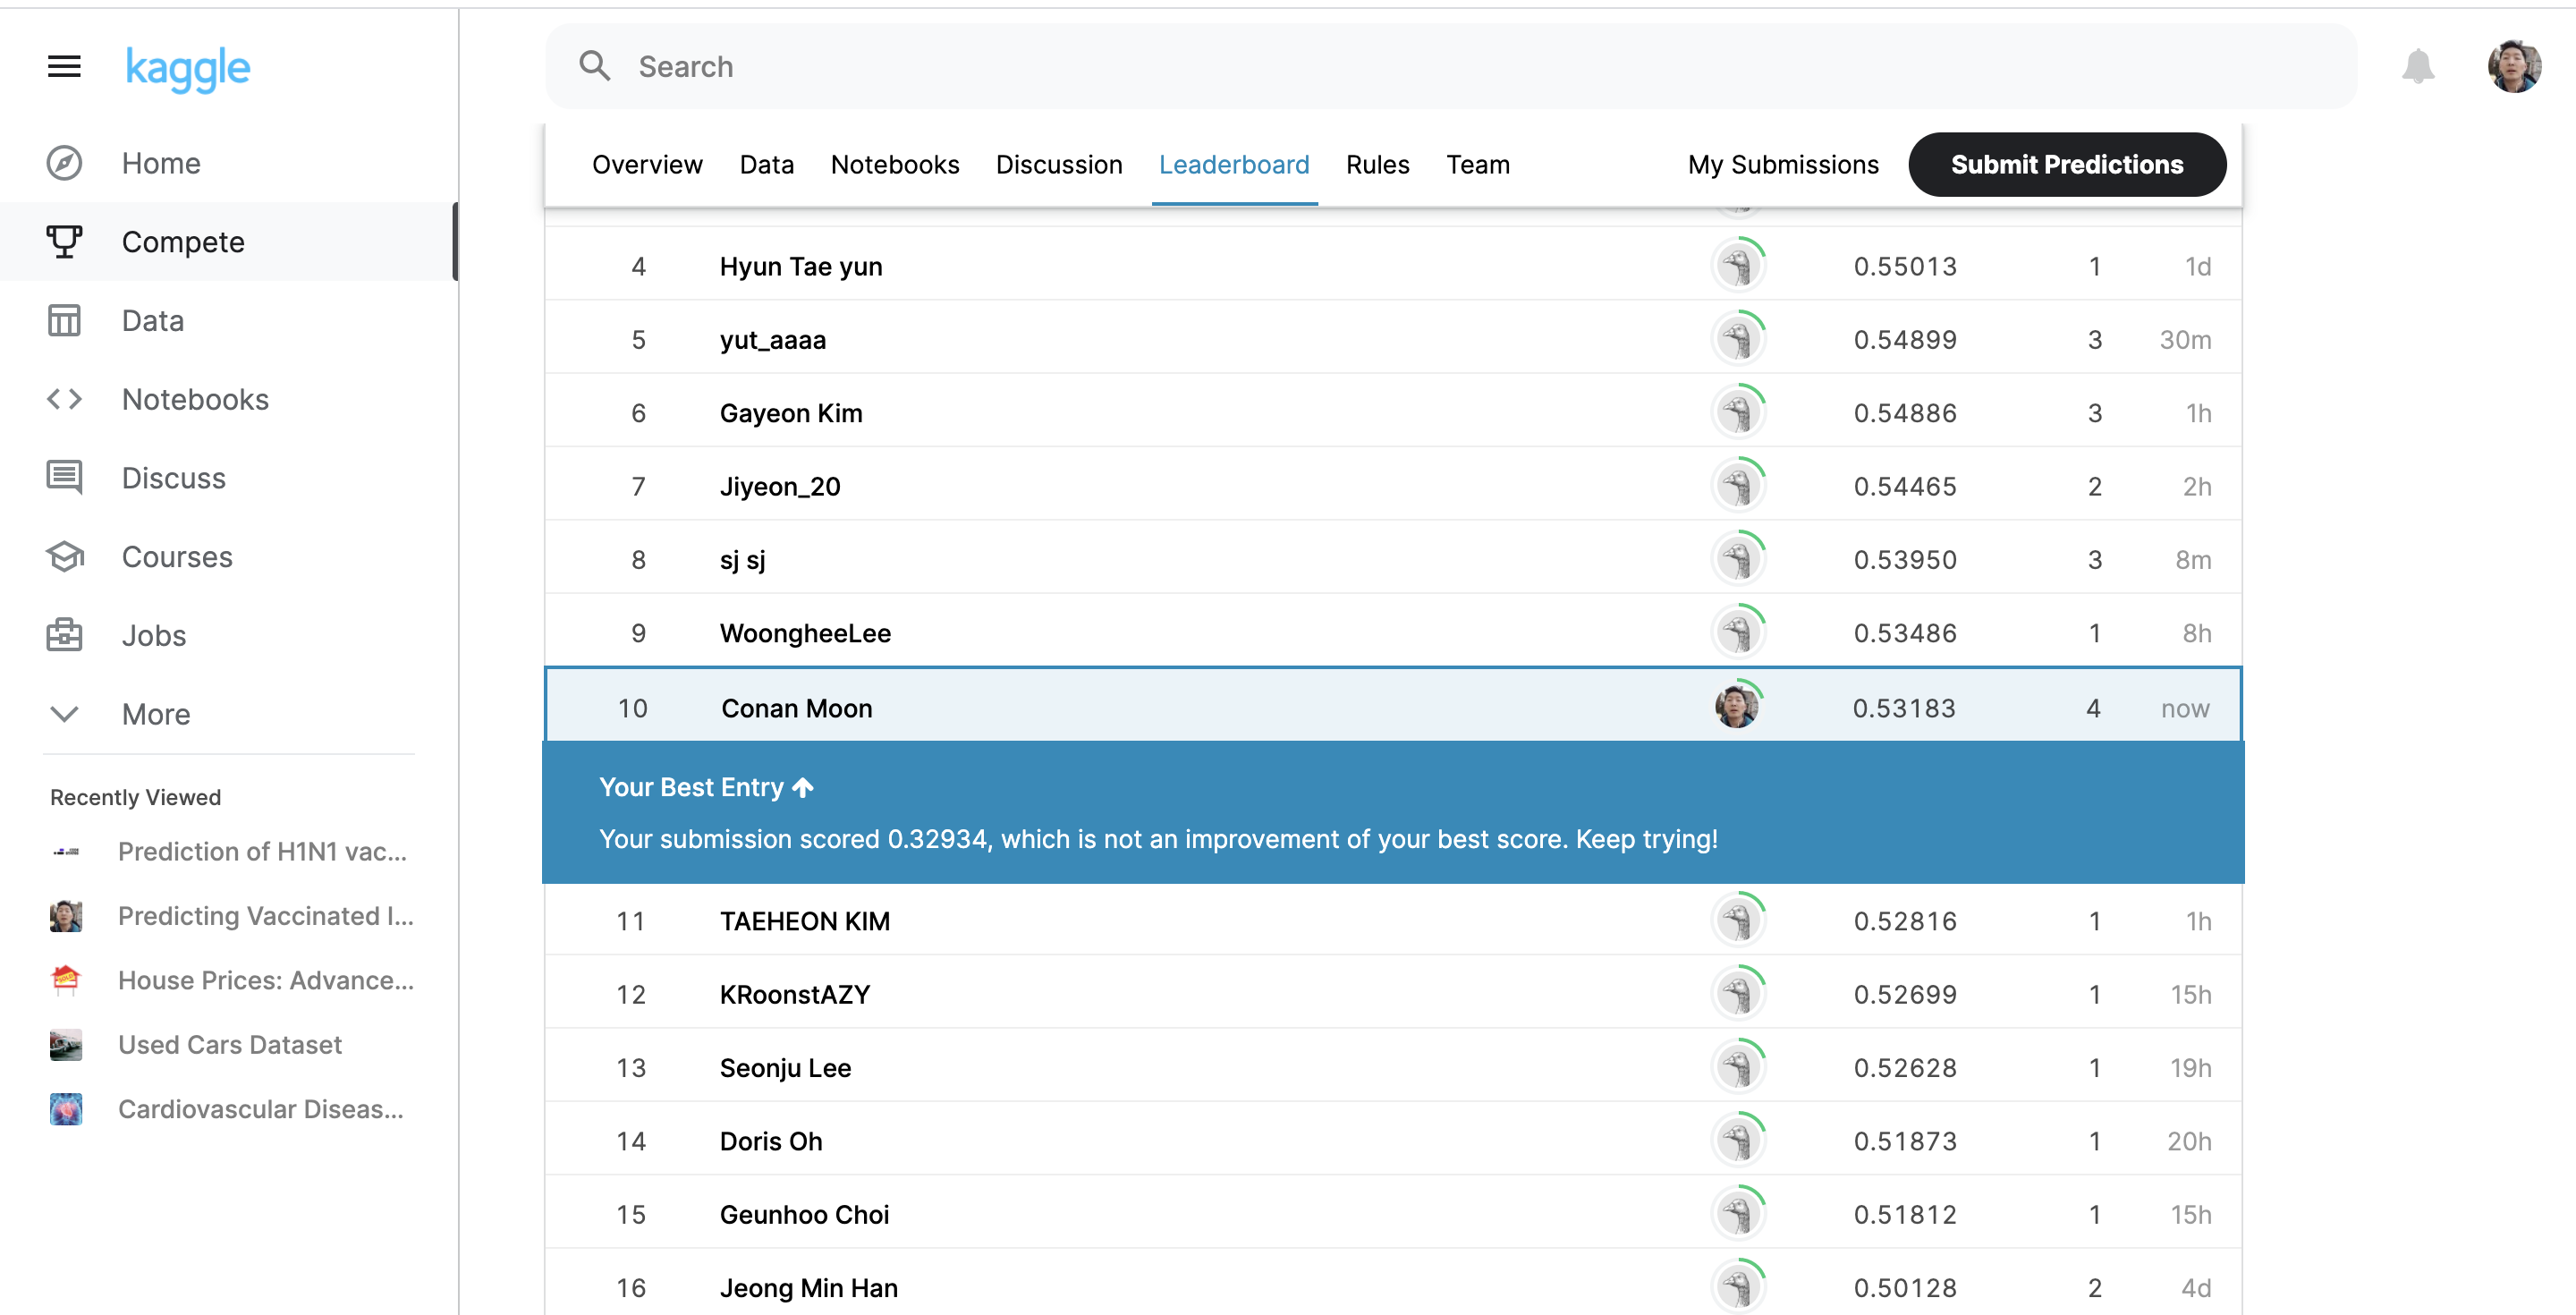

I would be happy to find out how others approached the problem. Please let me know down the comment below! 

Thanks for reading!